---

# **Time‑Series Resampling & Rolling Window Analysis**  
### *Exploring Multi‑Horizon Structure in Financial Data*

This mini‑project uses a historical OHLCV dataset for a single equity ticker to explore core time‑series techniques used in quantitative research. The focus is on **resampling**, **rolling window analysis**, and **time‑based slicing**, all of which are foundational tools for understanding how market behavior changes across different time horizons.

The project walks through:

- **Resampling** daily data into weekly and monthly frequencies to study how smoothing affects trend visibility  
- **Upsampling** to higher frequencies and handling missing values  
- **Rolling window calculations** such as moving averages, volatility, min/max ranges, and z‑scores  
- **Comparing features** across daily, weekly, monthly, and rolling perspectives  
- **Subsetting the time series** based on volatility, trend, and z‑score conditions  

These techniques matter in quant research because they reveal structure that is invisible at a single frequency. Resampling helps uncover long‑term trends, while rolling windows capture local behavior such as volatility clustering, mean reversion, and regime shifts. Together, they form the backbone of feature engineering, signal construction, and multi‑horizon modeling.

---

## Set-up

In [954]:
import pandas as pd
import numpy as np

In [955]:
file_Path = 'C:/Users/jgive/Documents/Python Projects/Mini Projects/Data/msft_intraday-30min_historical-data-03-17-2025.csv'
df = pd.read_csv(file_Path, index_col = 0, parse_dates = True)
msft_daily = pd.DataFrame()
msft_wkly = pd.DataFrame()
msft_monthly = pd.DataFrame()
msft_rolling = pd.DataFrame()

In [956]:
df.head()

,Open,High,Low,Last,Change,%Chg,Volume
Time,,,,,,,
2025-03-17 11:30:00,386.77,387.0100,385.57,385.920,-0.945,-0.24%,69970
2025-03-17 11:00:00,388.07,388.2700,386.74,386.865,-1.160,-0.30%,580599
2025-03-17 10:30:00,389.09,389.4400,387.53,388.025,-1.120,-0.29%,604599
2025-03-17 10:00:00,388.84,390.3107,387.37,389.145,0.355,+0.09%,766048
2025-03-17 09:30:00,386.70,389.9300,385.93,388.790,0.230,+0.06%,1259488


In [957]:
df

,Open,High,Low,Last,Change,%Chg,Volume
Time,,,,,,,
2025-03-17 11:30:00,386.7700,387.0100,385.5700,385.920,-0.945,-0.24%,69970
2025-03-17 11:00:00,388.0700,388.2700,386.7400,386.865,-1.160,-0.30%,580599
2025-03-17 10:30:00,389.0900,389.4400,387.5300,388.025,-1.120,-0.29%,604599
2025-03-17 10:00:00,388.8400,390.3107,387.3700,389.145,0.355,+0.09%,766048
2025-03-17 09:30:00,386.7000,389.9300,385.9300,388.790,0.230,+0.06%,1259488
...,...,...,...,...,...,...,...
2019-01-25 14:00:00,107.2564,107.3350,106.8500,106.930,-0.320,-0.30%,1373132
2019-01-25 13:30:00,107.2800,107.3200,107.1700,107.250,-0.024,-0.02%,843889
2019-01-25 13:00:00,107.3300,107.4600,107.1600,107.274,-0.066,-0.06%,1046711


---
### Converting %Chg column into decimal form

---
```python
df['%Chg'] = df['%Chg'].to_numeric/100
```
caused AttributeError: 'Series' object has no attribute 'to_numeric'

###  Fix:

- `str.replace('%','')` removes the percent sign  
- `pd.to_numeric(...)` converts the cleaned strings to floats  
- dividing by 100 converts percentages into **decimal returns**, which is the correct format for volatility calculations


In [960]:
df['%Chg'] = pd.to_numeric(df['%Chg'].str.replace('%',''))/100
df.head()

,Open,High,Low,Last,Change,%Chg,Volume
Time,,,,,,,
2025-03-17 11:30:00,386.77,387.0100,385.57,385.920,-0.945,-0.0024,69970
2025-03-17 11:00:00,388.07,388.2700,386.74,386.865,-1.160,-0.0030,580599
2025-03-17 10:30:00,389.09,389.4400,387.53,388.025,-1.120,-0.0029,604599
2025-03-17 10:00:00,388.84,390.3107,387.37,389.145,0.355,0.0009,766048
2025-03-17 09:30:00,386.70,389.9300,385.93,388.790,0.230,0.0006,1259488


In [961]:
df.loc['2025-3-14']

,Open,High,Low,Last,Change,%Chg,Volume
Time,,,,,,,
2025-03-14 15:30:00,388.1250,390.2300,387.9300,388.560,0.470,0.0012,5337901
2025-03-14 15:00:00,388.3850,388.6100,388.0800,388.090,-0.310,-0.0008,486502
2025-03-14 14:30:00,387.0700,388.4400,387.0700,388.400,1.345,0.0035,436077
2025-03-14 14:00:00,387.1400,387.8899,386.7743,387.055,-0.060,-0.0002,446738
2025-03-14 13:30:00,387.6629,387.9600,387.0701,387.115,-0.585,-0.0015,386159
2025-03-14 13:00:00,387.6500,388.3000,387.4600,387.700,-0.010,0.0000,422624
2025-03-14 12:30:00,386.0950,387.8492,385.9035,387.710,1.525,0.0039,402898
2025-03-14 12:00:00,387.0400,387.2500,386.1250,386.185,-0.810,-0.0021,424284
2025-03-14 11:30:00,385.2800,387.4000,385.0700,386.995,1.760,0.0046,827288


In [962]:
df

,Open,High,Low,Last,Change,%Chg,Volume
Time,,,,,,,
2025-03-17 11:30:00,386.7700,387.0100,385.5700,385.920,-0.945,-0.0024,69970
2025-03-17 11:00:00,388.0700,388.2700,386.7400,386.865,-1.160,-0.0030,580599
2025-03-17 10:30:00,389.0900,389.4400,387.5300,388.025,-1.120,-0.0029,604599
2025-03-17 10:00:00,388.8400,390.3107,387.3700,389.145,0.355,0.0009,766048
2025-03-17 09:30:00,386.7000,389.9300,385.9300,388.790,0.230,0.0006,1259488
...,...,...,...,...,...,...,...
2019-01-25 14:00:00,107.2564,107.3350,106.8500,106.930,-0.320,-0.0030,1373132
2019-01-25 13:30:00,107.2800,107.3200,107.1700,107.250,-0.024,-0.0002,843889
2019-01-25 13:00:00,107.3300,107.4600,107.1600,107.274,-0.066,-0.0006,1046711


## Setting the Index Resolution to daily

In [964]:
daily_open = df['Open'].resample('D').first()
daily_open.index = daily_open.index.to_period('D')
msft_daily['Open'] = daily_open

daily_high = df['High'].resample('D').max()
daily_high.index = daily_high.index.to_period('D')
msft_daily['High'] = daily_high

daily_low = df['Low'].resample('D').min()
daily_low.index = daily_low.index.to_period('D')
msft_daily['Low'] = daily_low

daily_close = df['Last'].resample('D').last()
daily_close.index = daily_close.index.to_period('D')
msft_daily['Close'] = daily_close

daily_volatility = df['%Chg'].resample('D').std()
daily_volatility.index = daily_volatility.index.to_period('D')
msft_daily['Volatility'] = daily_volatility
msft_daily = msft_daily.ffill()
msft_daily

,Open,High,Low,Close,Volatility
Time,,,,,
2019-01-25,107.810,107.8800,106.80,107.17,0.001781
2019-01-26,107.810,107.8800,106.80,107.17,0.001781
2019-01-27,107.810,107.8800,106.80,107.17,0.001781
2019-01-28,106.260,106.4800,104.66,105.09,0.005056
2019-01-29,104.880,104.9700,102.17,102.94,0.004890
...,...,...,...,...,...
2025-03-13,383.155,385.3200,377.45,378.77,0.003626
2025-03-14,379.775,390.2300,379.51,388.56,0.004732
2025-03-15,379.775,390.2300,379.51,388.56,0.004732


<Axes: xlabel='Time'>

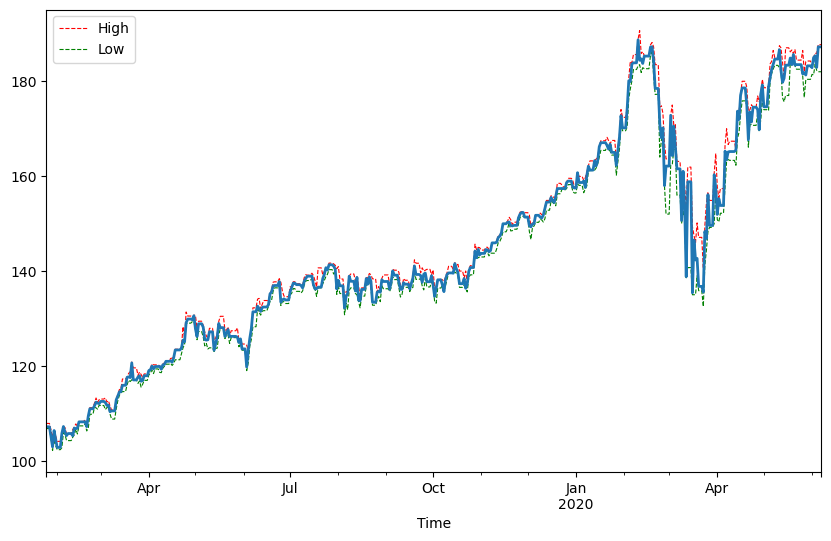

In [965]:
daily = msft_daily[['High', 'Low']].iloc[:500].plot(
figsize=(10, 6), style=['r--', 'g--',], lw=0.8) 
msft_daily['Close'].iloc[:500].plot(ax=daily, lw=2.0)

---

### **Daily Open**
```python
daily_open = df['Open'].resample('D').first()
```
Uses the **first intraday bar of the day**.

### **Daily High**
```python
daily_high = df['High'].resample('D').max()
```
Takes the **maximum high across all intraday bars**.

### **Daily Low**
```python
daily_low = df['Low'].resample('D').min()
```
Takes the **minimum low across all intraday bars**.

### **Daily Close**
```python
daily_close = df['Last'].resample('D').last()
```
Uses the **last intraday bar of the day**.

### **Daily Volatility (intraday realized volatility)**
```python
daily_volatility = df['%Chg'].resample('D').std()
```

This computes:

- the **standard deviation of all intraday returns** (your `%Chg` column)
- within each day  
- producing **one volatility value per day**

This is a valid and widely used measure called **daily realized volatility**.

---

### The index conversion is optional but consistent

```python
daily_open.index = daily_open.index.to_period('D')
```

This simply converts the index from a Timestamp to a PeriodIndex.  
It’s stylistic, not required, but it keeps the daily DataFrame clean.

---

## Setting the Index Resolution to weekly

In [968]:
msft_daily.index = msft_daily.index.to_timestamp()

In [969]:
wkly_open = msft_daily['Open'].resample('W').first()
msft_wkly['Open'] = wkly_open

wkly_high = msft_daily['High'].resample('W').max()
msft_wkly['High'] = wkly_high

wkly_low = msft_daily['Low'].resample('W').min()
msft_wkly['Low'] = wkly_low

wkly_close = msft_daily['Close'].resample('W').last()
msft_wkly['Close'] = wkly_close

wkly_volatility = msft_daily['Volatility'].resample('W').std()
msft_wkly['Volatility'] = wkly_volatility

msft_wkly

,Open,High,Low,Close,Volatility
Time,,,,,
2019-01-27,107.81,107.8800,106.800,107.1700,0.000000
2019-02-03,106.26,106.4800,102.170,102.8200,0.001611
2019-02-10,102.87,107.2600,102.770,105.7500,0.000681
2019-02-17,106.20,108.3000,104.965,108.2100,0.000638
2019-02-24,107.91,111.2000,106.290,110.9700,0.000713
...,...,...,...,...,...
2025-02-23,407.79,419.3100,405.880,408.2900,0.000515
2025-03-02,408.51,409.3700,386.570,397.2125,0.001231
2025-03-09,398.82,402.1500,381.000,393.3100,0.000873


<Axes: xlabel='Time'>

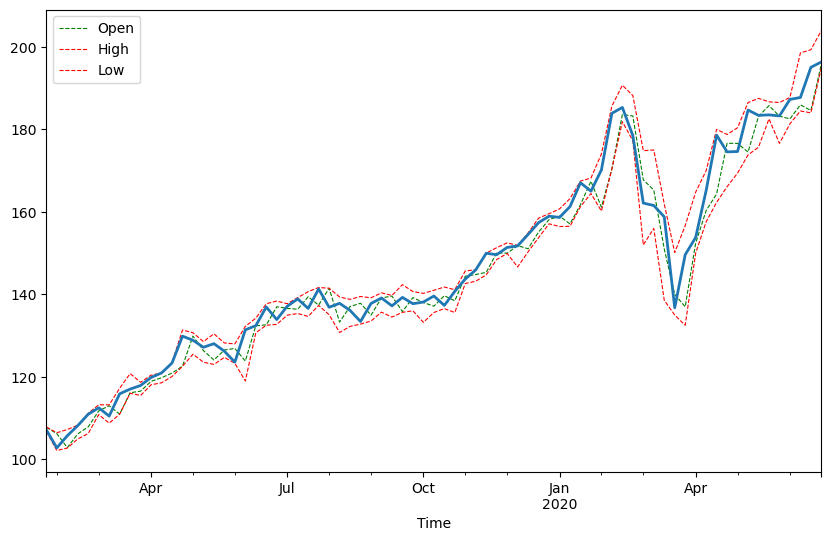

In [970]:
weekly = msft_wkly[['Open', 'High', 'Low']].iloc[:75].plot(
figsize=(10, 6), style=['g--', 'r--', 'r--',], lw=0.8) 
msft_wkly['Close'].iloc[:75].plot(ax=weekly, lw=2.0)

## Setting the Index Resolution to Monthly

In [972]:
monthly_open = msft_daily['Open'].resample('ME').first()
msft_monthly['Open'] = monthly_open

monthly_high = msft_daily['High'].resample('ME').max()
msft_monthly['High'] = monthly_high

monthly_low = msft_daily['Low'].resample('ME').min()
msft_monthly['Low'] = monthly_low

monthly_close = msft_daily['Close'].resample('ME').last()
msft_monthly['Close'] = monthly_close

monthly_volatility = msft_daily['Volatility'].resample('ME').std()
msft_monthly['Volatility'] = monthly_volatility

msft_monthly

,Open,High,Low,Close,Volatility
Time,,,,,
2019-01-31,107.810,107.8800,102.1700,104.4800,0.002298
2019-02-28,103.775,113.2400,102.3500,112.0600,0.000706
2019-03-31,112.890,120.8200,108.8000,117.9400,0.001141
2019-04-30,118.950,131.3700,118.1000,130.5800,0.001854
2019-05-31,130.530,130.6500,123.0400,123.5900,0.001122
...,...,...,...,...,...
2024-11-30,409.010,429.3250,405.5713,423.4600,0.001157
2024-12-31,420.090,456.1648,417.8000,421.5000,0.001978
2025-01-31,426.100,448.3800,410.7200,415.0600,0.002379


<Axes: xlabel='Time'>

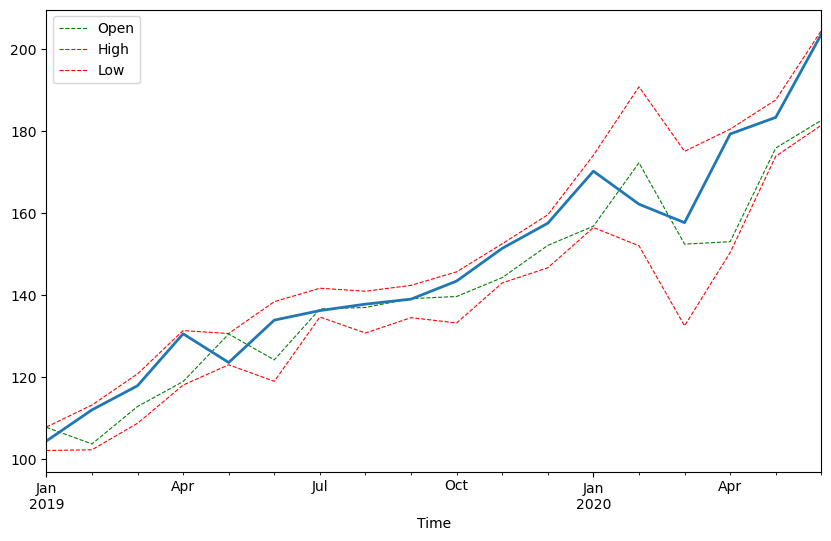

In [973]:
monthly = msft_monthly[['Open', 'High', 'Low']].iloc[:18].plot(
figsize=(10, 6), style=['g--', 'r--', 'r--',], lw=0.8) 
msft_monthly['Close'].iloc[:18].plot(ax=monthly, lw=2.0)

## Daily/Weekly/Monthly/Rolling Comparisons

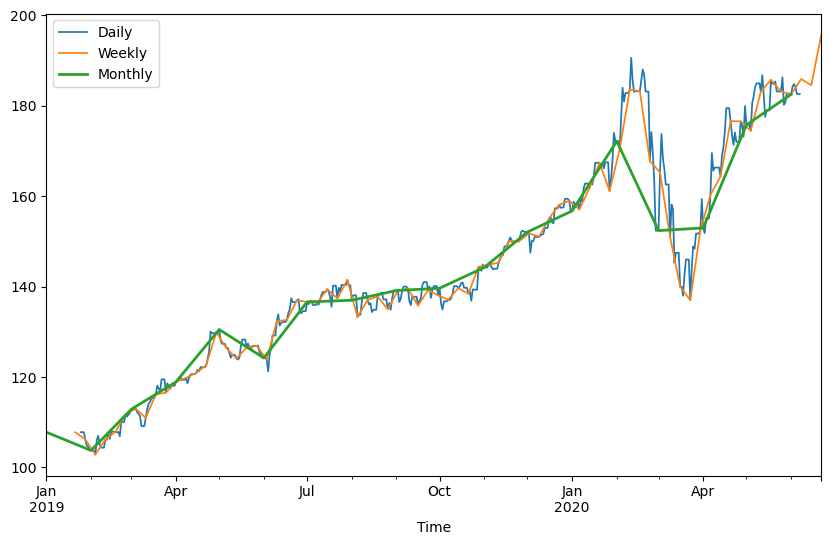

In [975]:
ax = msft_daily['Open'].iloc[:500].plot(figsize = (10,6),lw = 1.25, label = 'Daily')
plot =msft_wkly['Open'].iloc[:75].plot(ax=ax, lw = 1.25, label = 'Weekly')
msft_monthly['Open'].iloc[:18].plot(ax=plot, lw=2.0, label = 'Monthly').legend()

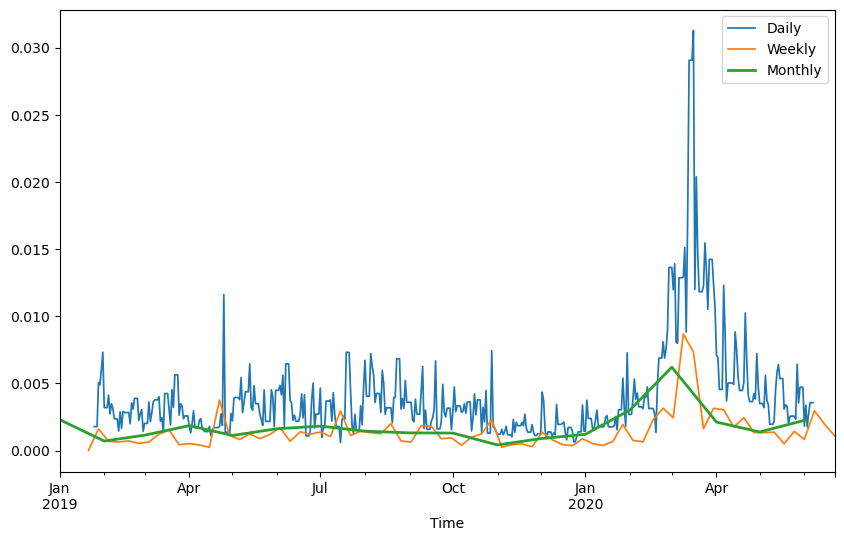

In [976]:
ax = msft_daily['Volatility'].iloc[:500].plot(figsize = (10,6),lw = 1.25, label = 'Daily')
plot =msft_wkly['Volatility'].iloc[:75].plot(ax=ax, lw = 1.25, label = 'Weekly')
msft_monthly['Volatility'].iloc[:18].plot(ax=plot, lw=2.0, label = 'Monthly').legend()

## Rolling Window Analysis

In [1036]:
msft_mean = (msft_daily['Open']+msft_daily['Close'])/2
msft_daily['Mean'] = msft_mean
rolling_return = msft_mean.pct_change()
msft_rolling['Mean'] = msft_mean.rolling(window=20).mean()
msft_rolling['High'] = msft_daily['High'].rolling(window=20).max()
msft_rolling['Low']  = msft_daily['Low'].rolling(window=20).min()
msft_rolling['Std'] = msft_mean.rolling(20).std()
msft_rolling['Volatility'] = rolling_return.rolling(window = 20).std()
msft_rolling['ZScore_20'] = ( (msft_mean - msft_rolling['Mean']) / msft_rolling['Std'] )

### Visualizing Rolling Windows

<Axes: xlabel='Time'>

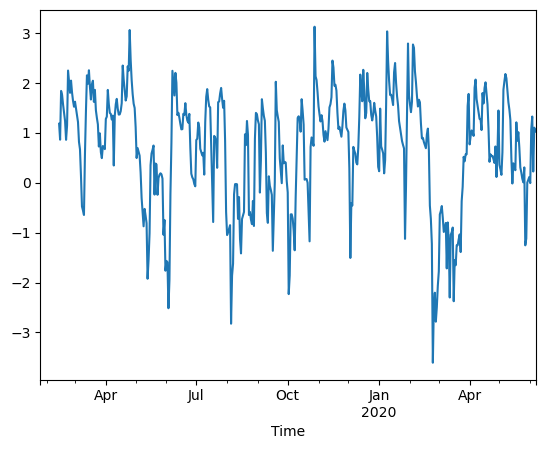

In [980]:
msft_rolling['ZScore_20'].iloc[:500].plot()

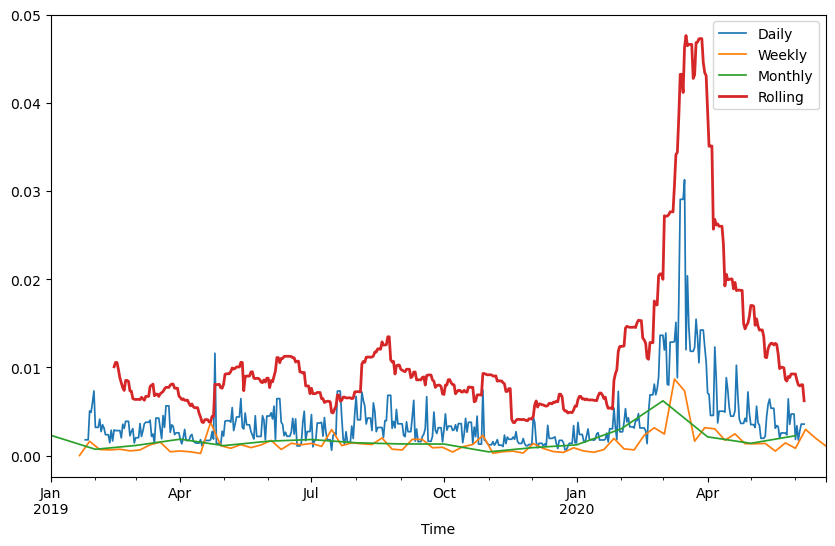

In [981]:
ax = msft_daily['Volatility'].iloc[:500].plot(figsize = (10,6),lw = 1.25, label = 'Daily')
plot =msft_wkly['Volatility'].iloc[:75].plot(ax=ax, lw = 1.25, label = 'Weekly')
combine = msft_monthly['Volatility'].iloc[:18].plot(ax=plot, lw=1.25, label = 'Monthly')
msft_rolling['Volatility'].iloc[:500].plot(ax = combine, lw =2.0, label = 'Rolling').legend()

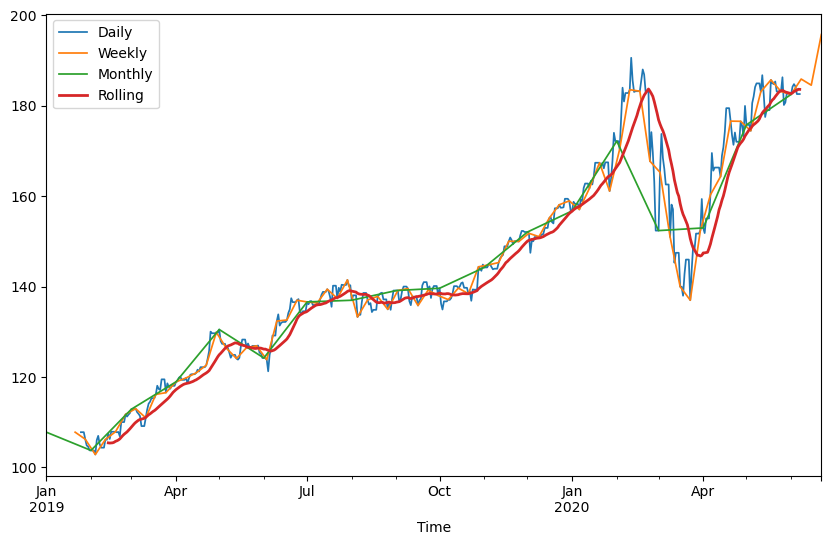

In [982]:
ax = msft_daily['Open'].iloc[:500].plot(figsize = (10,6),lw = 1.25, label = 'Daily')
plot =msft_wkly['Open'].iloc[:75].plot(ax=ax, lw = 1.25, label = 'Weekly')
combine = msft_monthly['Open'].iloc[:18].plot(ax=plot, lw=1.25, label = 'Monthly')
msft_rolling['Mean'].iloc[:500].plot(ax = combine, lw =2.0, label = 'Rolling').legend()

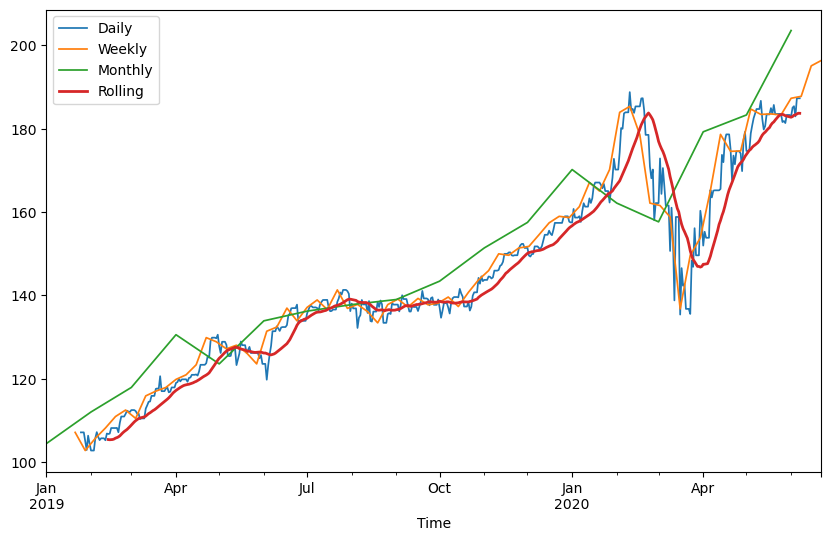

In [983]:
ax = msft_daily['Close'].iloc[:500].plot(figsize = (10,6),lw = 1.25, label = 'Daily')
plot =msft_wkly['Close'].iloc[:75].plot(ax=ax, lw = 1.25, label = 'Weekly')
combine = msft_monthly['Close'].iloc[:18].plot(ax=plot, lw=1.25, label = 'Monthly')
msft_rolling['Mean'].iloc[:500].plot(ax = combine, lw =2.0, label = 'Rolling').legend()

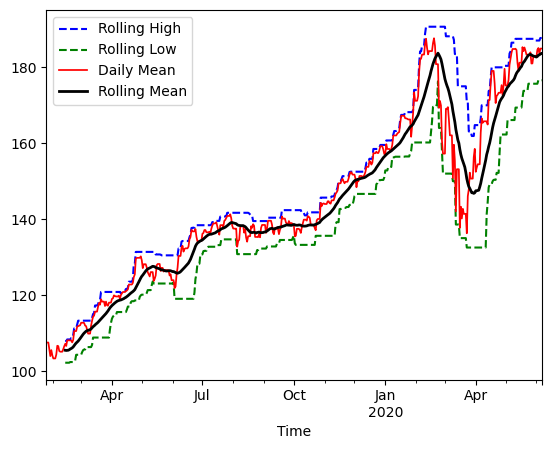

In [1034]:

roHI = msft_rolling['High'].iloc[:500].plot(lw =1.5, label = 'Rolling High',style=['b--'])
roLo = msft_rolling['Low'].iloc[:500].plot(ax = roHI, lw =1.5, label = 'Rolling Low',color='g', linestyle='--')
meanplt = msft_mean.iloc[:500].plot(ax=roLo,lw = 1.25, label = 'Daily Mean', style=['r'])
msft_rolling['Mean'].iloc[:500].plot(ax = meanplt, lw =2.0, label = 'Rolling Mean',style=['black']).legend()

## Analysis - *Subsetting Based on Rolling Features*

### High‑Volatility Periods

In [987]:
sorted_volatility = msft_rolling['Volatility'].iloc[:500].sort_values(ascending = False).dropna()
num = 480 * .9
diff = 480 - 432
filtered_sorted = sorted_volatility.iloc[0:diff]
filter_Volatility = msft_rolling[msft_rolling['Volatility'].isin(filtered_sorted)]
filter_Volatility

,Mean,High,Low,Std,Volatility,ZScore_20
Time,,,,,,
2020-02-27,180.971375,190.70,157.98,7.295606,0.020393,-2.783371
2020-02-28,179.666500,190.70,152.00,8.983175,0.020592,-2.493161
2020-02-29,178.361625,190.70,152.00,10.226650,0.020592,-2.062418
2020-03-02,175.993875,188.18,152.00,10.909204,0.027185,-0.634682
2020-03-03,175.189875,188.18,152.00,10.790788,0.027140,-0.567139
2020-03-04,174.494500,188.18,152.00,10.680054,0.027152,-0.466477
2020-03-05,173.588625,188.18,152.00,10.574203,0.027310,-0.702287
2020-03-06,172.478625,188.18,152.00,10.558017,0.027633,-0.984903
2020-03-07,171.368625,188.18,152.00,10.418050,0.027633,-0.891590


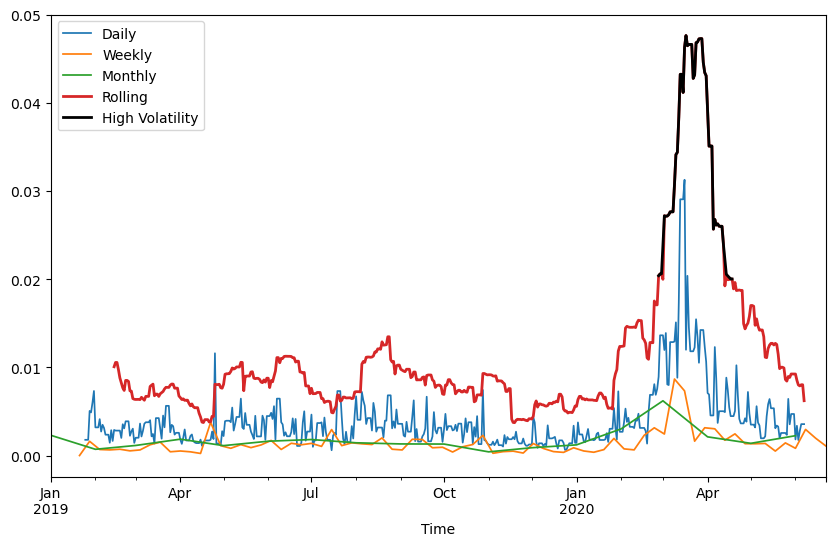

In [988]:
ax = msft_daily['Volatility'].iloc[:500].plot(figsize = (10,6),lw = 1.25, label = 'Daily')
plot =msft_wkly['Volatility'].iloc[:75].plot(ax=ax, lw = 1.25, label = 'Weekly')
combine = msft_monthly['Volatility'].iloc[:18].plot(ax=plot, lw=1.25, label = 'Monthly')
rolling = msft_rolling['Volatility'].iloc[:500].plot(ax = combine, lw =2.0, label = 'Rolling')
filter_Volatility['Volatility'].iloc[:500].plot(ax = combine, lw =2.0, label = 'High Volatility', style ='k').legend()

### Oversold Periods

In [990]:
Zscore_20 = pd.to_numeric(msft_rolling['ZScore_20'])
condition = Zscore_20 < -2

In [1054]:
oversold_msft = msft_rolling[condition]
oversold_msft_upsampled = oversold_msft.reindex(msft_rolling.index)

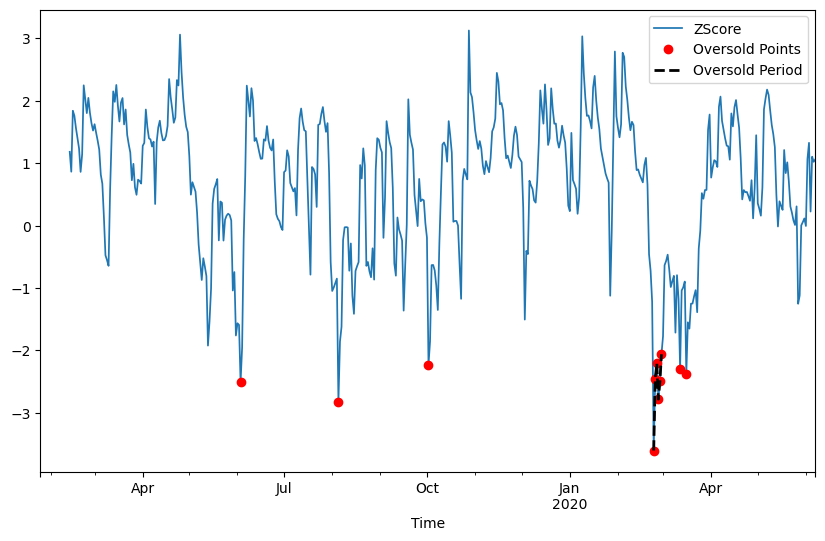

In [1068]:
ax = msft_rolling['ZScore_20'].iloc[:500].plot(figsize = (10,6),lw = 1.25, label = 'ZScore')
oversold_points = oversold_msft['ZScore_20'].loc['2019-01':'2020-04'].plot(ax=ax, lw = 2, label = 'Oversold Points', style = 'ro')
oversold_msft_upsampled['ZScore_20'].loc['2019-01':'2020-04'].plot(ax=oversold_points, lw = 2, label = 'Oversold Period', style = 'k--').legend()

Number of times oversold between January 2019 to April 2020

In [994]:
times_oversold_inPeriod = len(oversold_msft['ZScore_20'].loc['2019-01':'2020-04'])
times_oversold_inPeriod

11

### Trend-Following Periods

In [1038]:
trend = pd.to_numeric(msft_mean)> pd.to_numeric(msft_rolling['Mean'])

In [1040]:
msft_trend = msft_daily[trend]
msft_trend

,Open,High,Low,Close,Volatility,Mean
Time,,,,,,
2019-02-13,107.500,107.780,106.7100,106.7833,0.001651,107.14165
2019-02-14,106.310,107.290,105.6600,106.8750,0.002903,106.59250
2019-02-15,107.910,108.300,107.3624,108.2100,0.002826,108.06000
2019-02-16,107.910,108.300,107.3624,108.2100,0.002826,108.06000
2019-02-17,107.910,108.300,107.3624,108.2100,0.002826,108.06000
...,...,...,...,...,...,...
2025-01-29,446.690,446.880,440.4000,442.3300,0.004577,444.51000
2025-02-20,415.290,419.310,412.5400,416.1300,0.002567,415.71000
2025-02-21,417.335,418.048,407.8900,408.2900,0.001908,412.81250


In [1042]:
msft_daily

,Open,High,Low,Close,Volatility,Mean
Time,,,,,,
2019-01-25,107.810,107.8800,106.80,107.17,0.001781,107.4900
2019-01-26,107.810,107.8800,106.80,107.17,0.001781,107.4900
2019-01-27,107.810,107.8800,106.80,107.17,0.001781,107.4900
2019-01-28,106.260,106.4800,104.66,105.09,0.005056,105.6750
2019-01-29,104.880,104.9700,102.17,102.94,0.004890,103.9100
...,...,...,...,...,...,...
2025-03-13,383.155,385.3200,377.45,378.77,0.003626,380.9625
2025-03-14,379.775,390.2300,379.51,388.56,0.004732,384.1675
2025-03-15,379.775,390.2300,379.51,388.56,0.004732,384.1675


In [1050]:
msft_trend_upsampled = msft_trend.reindex(msft_daily.index)

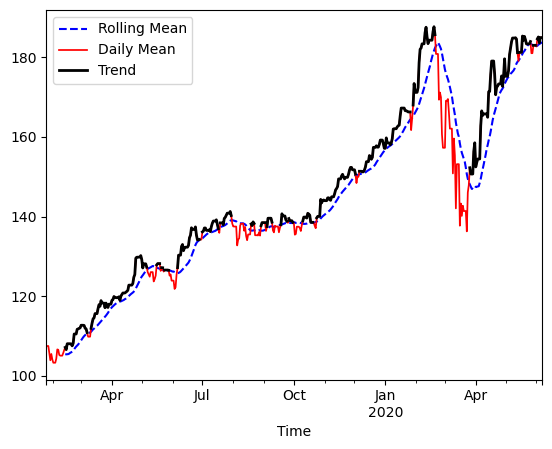

In [1052]:
rolling_mean_plt = msft_rolling['Mean'].iloc[:500].plot(lw =1.5, label = 'Rolling Mean',style=['b--'])
daily_mean_plt = msft_mean.iloc[:500].plot(ax = rolling_mean_plt,lw = 1.25, label = 'Daily Mean', style=['r'])
msft_trend_upsampled['Mean'].iloc[:500].plot(ax = daily_mean_plt , lw =2.0, label = 'Trend',style=['black']).legend()